In [ ]:
! pip install tensorflow_addons

     |████████████████████████████████| 679 kB 7.8 MB/s 


# **Pick a cover photo for the real estate listings**

### **Project Motivation**

The world we live in today is a digital one and searching for a home is no different. The typical buyer searches for properties online by checking websites with available images of a house. Most of the websites(zillow, trulia, realtor.com and others) are structured in a way that potential buyer sees a cover image first before other photos of a listed house and that is why it is extremely important to select that picture wisely. Many sellers (homeowners, real estate agents, brokers...),however, do not pay enough attention to the quality of a listing photos of a houses so, the goal of my project is to help sellers to pick the best cover photos of their houses to sell them faster.


### **Dataset**


I have been considering 2 options to collect the relevant data for my project:

1. Extract data from websites.
2. Use existing datasets.

I could not extract enough data from the websites because of their security measures so I decided to search for existing datasets. I found two good datasets on Kaggle and Github:

Github - https://github.com/emanhamed/Houses-dataset.git

Kaggle - https://www.kaggle.com/ted8080/house-prices-and-images-socal 

After analyzing both of them, I have decided to continue with Github dataset. Even though it contains smaller number of pictures (2,136) compare to one from Kaggle (15,000), I chose Github dataset because it has 4 images for each house ( bedroom, bathroom, kitchen and a frontal image of the house) which is exactly what I need for my project because not only the front image of a house can be the best option to present a house(the dataset from Kaggle contains mostly front images of houses).


### Dataset Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
! git clone https://github.com/emanhamed/Houses-dataset.git

fatal: destination path 'Houses-dataset' already exists and is not an empty directory.


In [ ]:
# Import necessary libraries
from typing import Iterator, List, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

import tensorflow_addons as tfa

In [ ]:
# Import and preview the data
houses = pd.read_csv('Houses-dataset/Houses Dataset/HousesInfo.txt', sep=' ')
houses.columns = ['bedrooms', 'bathrooms', 'area', 'zipcode', 'price']
display(houses.info())
houses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   534 non-null    int64  
 1   bathrooms  534 non-null    float64
 2   area       534 non-null    int64  
 3   zipcode    534 non-null    int64  
 4   price      534 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 21.0 KB


None

,bedrooms,bathrooms,area,zipcode,price
0,4,3.0,3343,36372,865200
1,3,4.0,3923,85266,889000
2,5,5.0,4022,85262,910000
3,3,4.0,4116,85266,971226
4,4,5.0,4581,85266,1249000


In [ ]:
# Find missing values
houses.isnull().sum()

bedrooms     0
bathrooms    0
area         0
zipcode      0
price        0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


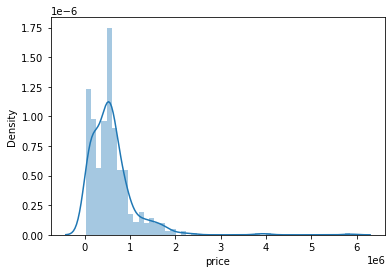

In [ ]:
# Display price distribution
sns.distplot(houses["price"]);


In [ ]:
# path for the image locations.
houses['image_id'] = houses.index + 1
views = ['frontal', 'bathroom', 'bedroom', "kitchen"]
data = []
for i, row in houses.iterrows():
    curr_price = row['price']
    curr_id = row['image_id']
    for v in views:
        data.append([curr_price, f"Houses-dataset/Houses Dataset/{int(curr_id)}_{v}.jpg"])

data = pd.DataFrame(data, columns=['price', 'image_path'])
print(data.shape)
data.head()

(2136, 2)


,price,image_path
0,865200.0,Houses-dataset/Houses Dataset/1_frontal.jpg
1,865200.0,Houses-dataset/Houses Dataset/1_bathroom.jpg
2,865200.0,Houses-dataset/Houses Dataset/1_bedroom.jpg
3,865200.0,Houses-dataset/Houses Dataset/1_kitchen.jpg
4,889000.0,Houses-dataset/Houses Dataset/2_frontal.jpg


In [ ]:
# split data
train_houses, valid_houses = train_test_split(data, test_size=0.1, random_state=179)


In [ ]:
# constant baseline which I will try to beat 
bestconst = np.mean(train_houses['price'])
bestconts_error = np.mean(np.square(valid_houses['price'] - bestconst))
bestconst, bestconts_error

(589041.5390218522, 289255608280.45056)

## Visualize Keras Data Augmentations and Create ImageDataGenerators



Found 2 validated image filenames.


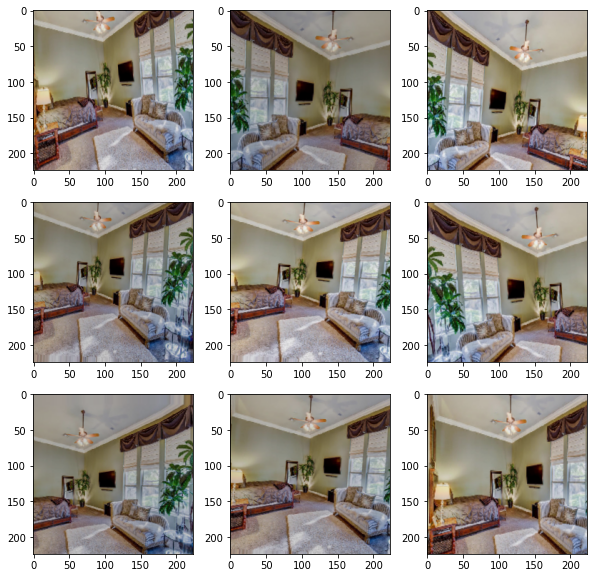

Found 1922 validated image filenames.
Found 214 validated image filenames.


In [ ]:
# Define a function to look into my data augmentations to make sure that they make sense in a real-world application.
def visualize_augmentations(data_generator: ImageDataGenerator, df: pd.DataFrame):
  
  # super hacky way of creating a small dataframe with one image
    series = df.iloc[2]

    df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()

    plt.figure(figsize=(10, 10))
    iterator_visualizations = data_generator.flow_from_dataframe(  # type: ignore
        dataframe = df_augmentation_visualization,
        x_col = "image_path",
        y_col = "price",
        class_mode = "raw",
        target_size = (224, 224),  # size of the image
        batch_size = 1,  # use only one image for visualization
    )

    # sample the same image 9 times 
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
        batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
        img = batch[0]  # type: ignore
        img = img[0, :, :, :]  # remove one dimension for plotting without issues
        plt.imshow(img)
    plt.show()
    plt.close()
  

# Define a function that takes my input data and creates two Keras ImageDataGenerators, one for each split of the data.
def create_generators(
    df: pd.DataFrame, train: pd.DataFrame, val: pd.DataFrame, visualize=False
) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts three Pandas DataFrames: all my data, the training and validation. Creates and returns
    keras ImageDataGenerators. 

    Parameters
    ----------
    df : pd.DataFrame
        Pandas DataFrame containing all my data.
    train : pd.DataFrame
        Pandas DataFrame containing my training data.
    val : pd.DataFrame
        Pandas DataFrame containing your validation data.
   

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training and validating of my models.
    """
    # create an ImageDataGenerator with multiple image augmentations
    train_generator = ImageDataGenerator(
        rescale = 1.0 / 255,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        brightness_range = (0.75, 1),
        shear_range = 0.1,
        zoom_range = [0.75, 1],
        horizontal_flip = True,
        validation_split = 0.2,
    )  
    
    # except for rescaling, no augmentations are needed for validation and testing generators
    validation_generator = ImageDataGenerator(
        rescale=1.0 / 255
    )  
    test_generator = ImageDataGenerator(rescale = 1.0 / 255)
    
    # visualize image augmentations
    if visualize:
        visualize_augmentations(train_generator, df)

    train_generator = train_generator.flow_from_dataframe(
        dataframe = train,
        x_col = "image_path",  # this is where my image data is stored
        y_col = "price",  # this is my target feature
        class_mode = "raw",  # use "raw" for regressions
        target_size = (224, 224),
        batch_size = 128, # increase or decrease to fit your GPU
    )

    validation_generator = validation_generator.flow_from_dataframe(
        dataframe = val,
        x_col = "image_path",
        y_col = "price",
        class_mode = "raw",
        target_size = (224, 224),
        batch_size = 128,
    )
    return train_generator, validation_generator
  
train_generator, validation_generator = create_generators(data, train_houses, valid_houses, True)

The resulting plot shows the same picture, sometimes a bit rotated, mirrored, or zoomed in with minor brightness adjustments. Nevertheless, each image is clearly recognizable as the same room and should improve my models, which was my goal in adding the augmentations.

## Modeling

In [ ]:
# Define a function for model architecture  - Adapted EfficientNet
def adapt_efficient_net() -> Model:
    """This code adapts most up-to-date version of EfficientNet to a regression
    problem. Most of this code is adapted from the official keras documentation.

    Returns
    -------
    Model
        The keras model.
    """
    # input shapes of the images 224x224x3
    inputs = layers.Input(
        shape=(224, 224, 3)
    )  
    
    # use the downloaded and converted newest EfficientNet wheights
    model = EfficientNetB0(include_top = False, input_tensor = inputs, weights = "imagenet")
    model.trainable = False

    # Head of my regression model
    x = layers.GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name = "top_dropout")(x)
    outputs = layers.Dense(1, name ="pred")(x)

    model = keras.Model(inputs, outputs, name = "EfficientNet")

    return model

# Define a function for model architecture  - small cnn
def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.

    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1))

    return model

# Define a function for model architecture  - Simple Dense model	
def small_dense() -> Sequential:
    model = keras.Sequential(
      [
          layers.Flatten(),
          layers.Dense(128, activation="relu"),
          layers.Dense(54, activation="relu"),
          layers.Dense(1),
      ]
    )
    return model
  

# Define a function to run a model
def run_model(
    model_name: str,
    model_function: Model,
    lr: float,
    train_generator: Iterator,
    validation_generator: Iterator
) -> History:
    """This function runs a keras model. The model is evaluated within
    training through the validation generator.
    
    Parameters
    ----------
    model_name : str
        The name of the model as a string.
    model_function : Model
        Keras model function like small_cnn()  or adapt_efficient_net().
    lr : float
        Learning rate.
    train_generator : Iterator
        keras ImageDataGenerators for the training data.
    validation_generator : Iterator
        keras ImageDataGenerators for the validation data.
    

    Returns
    -------
    History
        The history of the keras model as a History object.
    """

    # write a few callbacks that I add to my models
    callbacks = get_callbacks(model_name)
    model = model_function
    plot_model(model, to_file = model_name + ".jpg", show_shapes = True)


    # use the optimizer from Keras
    from keras.optimizers import Adam

    opt = Adam(learning_rate = lr, decay = 1e-3 / 200)

    model.compile(
        optimizer = opt, loss = "mse", metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
    history = model.fit(
        train_generator,
        epochs = 100,
        validation_data = validation_generator,
        callbacks = callbacks,
        workers = 6, # adjust this according to the number of CPU cores of my machine
    )

    return history  # type: ignore

In [ ]:
# Define a function which saves model's trained weights every epoch
def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.

    Parameters
    ----------
    model_name : str
        The name of the model as a string.

    Returns
    -------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """
    # create a folder for each model.
    logdir = (
        "logs/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  
    # use tensorboard --logdir logs/scalars in my command line to startup tensorboard with the correct logs
    tensorboard_callback = TensorBoard(log_dir=logdir)


    early_stopping_callback = EarlyStopping(
        monitor = "val_mean_absolute_percentage_error",
        min_delta = 1,  # model should improve by at least 1%
        patience = 20,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose = 2,
        mode = "min",
        restore_best_weights = True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        "./project5_data/" + model_name,
        monitor = "val_mean_absolute_percentage_error",
        save_best_only = True,  # save the best model
        mode = "min",
        save_freq = "epoch",  # save every epoch
    )  # saving eff_net takes quite a bit of time
    return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]


In [ ]:
# Run 3 models
model1 = small_dense()
history1 = run_model("dense_net", model1, 0.1, train_generator, validation_generator)
model2 = small_cnn()
history2 = run_model("small_cnn", model2, 0.1, train_generator, validation_generator)
model3 = adapt_efficient_net()
history3 = run_model("adapt_efficient_net", model3, 0.1, train_generator, validation_generator)


Epoch 1/100
16/16 [==============================] - 201s 11s/step - loss: 331018829824.0000 - mean_absolute_error: 390621.5938 - mean_absolute_percentage_error: 124.8504 - val_loss: 297512304640.0000 - val_mean_absolute_error: 339550.7500 - val_mean_absolute_percentage_error: 140.6612
INFO:tensorflow:Assets written to: ./project5_data/dense_net/assets
Epoch 2/100
16/16 [==============================] - 52s 2s/step - loss: 270631698432.0000 - mean_absolute_error: 341806.1875 - mean_absolute_percentage_error: 129.1239 - val_loss: 301356810240.0000 - val_mean_absolute_error: 344959.1250 - val_mean_absolute_percentage_error: 150.9220
Epoch 3/100
16/16 [==============================] - 57s 2s/step - loss: 270482325504.0000 - mean_absolute_error: 338552.5625 - mean_absolute_percentage_error: 126.5062 - val_loss: 289568653312.0000 - val_mean_absolute_error: 320506.5312 - val_mean_absolute_percentage_error: 125.2863
INFO:tensorflow:Assets written to: ./project5_data/dense_net/assets
Epoch 4

KeyboardInterrupt: ignored

In [ ]:
# Compare 3 models 
losses = pd.DataFrame(
    [["Const", str(int(bestconts_error))],
     ["Simple Dense model", str(int(history1.history['val_loss'][0]))],
     ["Simple CNN", str(int(history2.history['val_loss'][0]))],
     ['Adapted EfficientNet', str(int(history3.history['val_loss'][0]))]
    ],
     columns = ['Model', "Validation MSE"]
)

losses

,Model,Validation MSE
0,Const,289255608280
1,Simple Dense model,280858730488
2,Simple CNN,272340692529
3,Adapted EfficientNet,240934572092


Adapted EfficientNet	model is the best one based on Validation error.



## Results

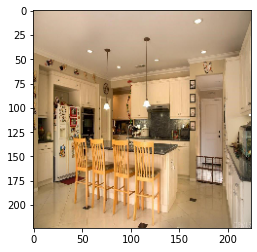

true price: 550000.0$, predicted: 413991.2$
-------------------



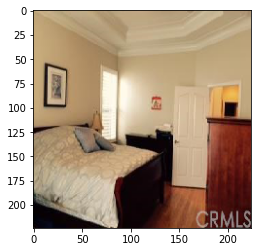

true price: 1199000.0$, predicted: 446447.23$
-------------------



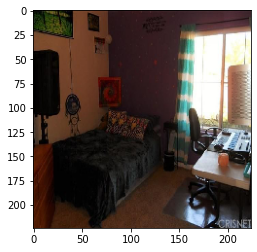

true price: 5858000.0$, predicted: 679391.32$
-------------------



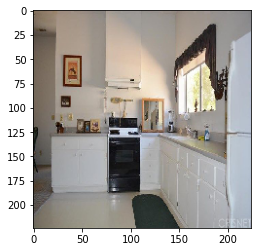

true price: 400000.0$, predicted: 406488.83$
-------------------



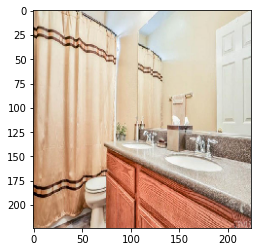

true price: 529900.0$, predicted: 412995.26$
-------------------



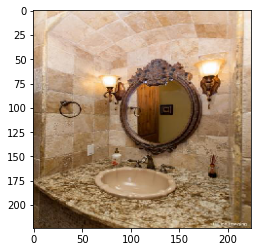

true price: 865200.0$, predicted: 429759.28$
-------------------



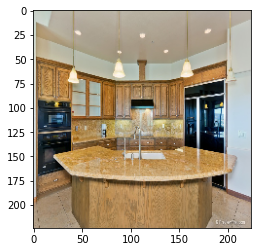

true price: 749900.0$, predicted: 423979.22$
-------------------



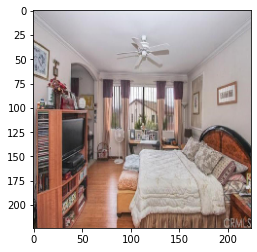

true price: 529900.0$, predicted: 412987.42$
-------------------



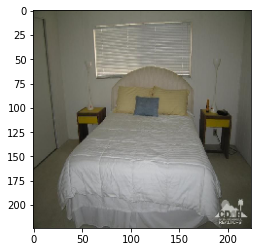

true price: 117500.0$, predicted: 392374.51$
-------------------



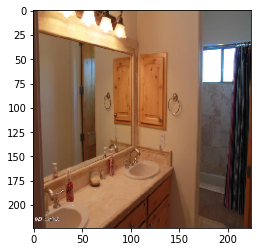

true price: 740000.0$, predicted: 423492.72$
-------------------



In [ ]:
# visualize predicted and true price

import matplotlib.pylab as plt

for x_batch, y_batch in validation_generator:
    prices = model(x_batch)
    for i, pic in enumerate(x_batch[:10]):
        plt.imshow(pic)
        plt.show()
        print(f"true price: {y_batch[i]}$, predicted: {round(prices[i].numpy()[0], 2)}$")
        print('-------------------')
        print()
    break

## Summary

In this project I used ImageDataGenerators and Pandas DataFrames to load my dataset then I augmented my images to improve prediction results; next, I plotted augmentations. Also, I adapted EfficientNet to a regression. In my modeling section I built 3 models (Simple Dense Model, Simple CNN and Adapted EfficientNet) and compared their results. Based on validation error results, AdaptedEfficientNet has the lowest validation score (240934572092) so I managed to beat a benchmark (289255608280) and visualize predicted and true price. This is a minimum viable product and requieres future improvements.

## Future work

1. Gather more data

2. Arrange pictures in order (from the most "expensive" to the "cheapest")

3. Find some general patterns which can make a picture look better.
